In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random

In [2]:
def insertGambar(folder):
    images = [] 
    filenames = [] 
    labels = [] 

    for label in os.listdir(folder): 
        for filename in os.listdir("dataset/"+label): 
            img = cv.imread(os.path.join("dataset/"+label,filename), 255) 
            filenames.append(filename) 
            labels.append(label) 
            if img is not None: 
                images.append(img) 
    return images, filenames, labels 

images, filenames, labels = insertGambar("dataset")

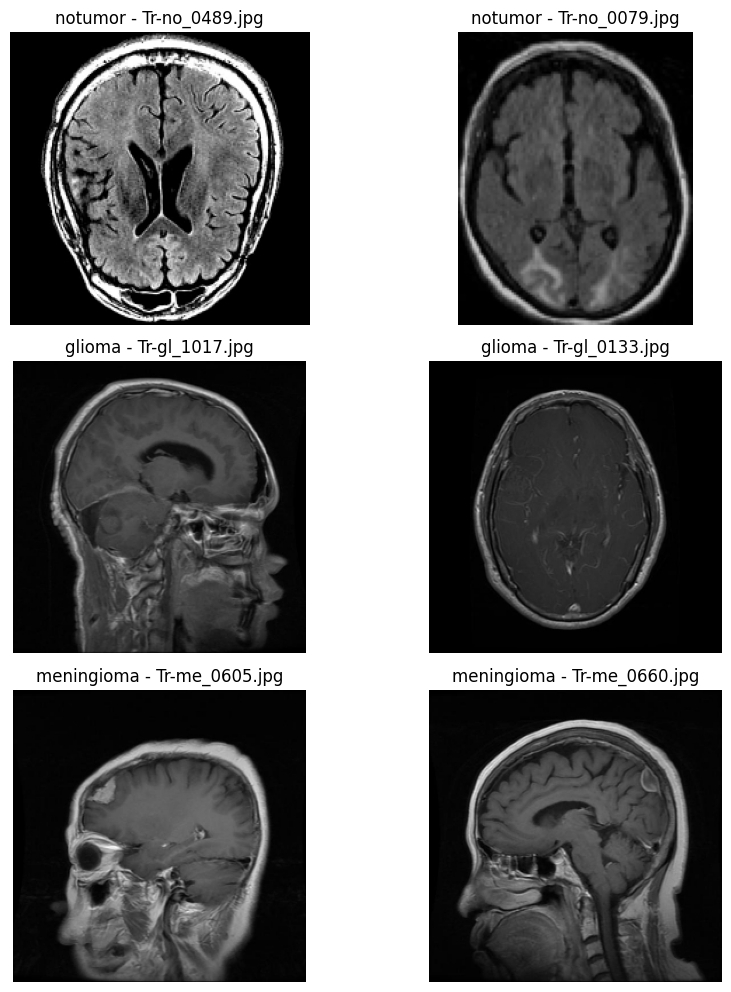

In [3]:
labels_to_display = ['notumor', 'glioma', 'meningioma']
max_images_per_label = 2

fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

for row, label in enumerate(labels_to_display):

    filtered_images = [(img, filename) for img, filename, img_label in zip(images, filenames, labels) if img_label == label]
    
    random.shuffle(filtered_images)
    
    for col in range(min(max_images_per_label, len(filtered_images))):
        img, filename = filtered_images[col]
        ax = axes[row, col]
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax.set_title(f"{label} - {filename}")
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()